# Assignment 4 – Privacy-Preserving Federated Learning Simulation (Breast Cancer Dataset)

TODO: **Note: Although this is a breast cancer dataset, you should frame findings in a way that could be ported to SeleneX (e.g., how to handle site heterogeneity, privacy budgets, and model monitoring when we later swap in ovarian features).**

### Objective

Simulate federated learning across two “hospitals” using the Breast Cancer Wisconsin (Diagnostic) dataset without sharing raw data. Add a differential-privacy layer, compare against centralized training, and document privacy/utility trade-offs.

## 0. Imports & Setup

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets, model_selection, preprocessing, utils

import matplotlib.pyplot as plt
import flwr as fl               #type: ignore

import torch, opacus, yaml, os, random  # type: ignore


# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Fixed seeds for reproducibility
RANDOM_SEED = config['values']['RANDOM_SEED']
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(RANDOM_SEED)

# ---------------------------- DIRECTORY CREATION ---------------------------- #
# doc/ directory
docs_dir = os.path.join('..', config['directories']['docs'])
os.makedirs(docs_dir, exist_ok=True)

# subdirectories for plots
pdf_dir = os.path.join(docs_dir, 'figures_as_pdf')
png_dir = os.path.join(docs_dir, 'figures_as_png')
os.makedirs(pdf_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)

## 1. Data Loading and EDA (Centralized, Local Only)

### 1.1 Load with load_breast_cancer(return_X_y=True, as_frame=True)

In [22]:
# Load the breast cancer dataset
X_data: pd.DataFrame
y_data: pd.Series
X_data, y_data = datasets.load_breast_cancer(return_X_y=True, as_frame=True)    # type: ignore

In [23]:
X_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [24]:
y_data.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

### 1.2 Confirm target mapping (document “0=malignant, 1=benign” or vice-versa)

**0 = malignant, 1 = benign | standard in this dataset**

In [25]:
# Official target mapping
data = datasets.load_breast_cancer()  # this variable is deleted at the end of this cell
print("Official target names from dataset:", data.target_names)   #type: ignore
print("Unique target values:", np.unique(data.target))            #type: ignore

# Verify the mapping
print("\nOfficial label mapping:")
for i, name in enumerate(data.target_names):                      #type: ignore
    count = (data.target == i).sum()                              #type: ignore
    print(f"{i}: {name} - {count} samples")

assert len(data.target) == len(y_data), f"LENGTH MISMATCH: y_data has {len(y_data)} samples, but data.target has {len(data.target)} samples"    #type: ignore
print("\nPASS: Length of y_data matches the length of data.target")

del data # Clean up memory

Official target names from dataset: ['malignant' 'benign']
Unique target values: [0 1]

Official label mapping:
0: malignant - 212 samples
1: benign - 357 samples

PASS: Length of y_data matches the length of data.target


### 1.3 Basic EDA

In [26]:
def save_plot(fig, filename):
    """Save the plot to the specified directory with separate folders for PNG and PDF."""
    fig.savefig(os.path.join(png_dir, f"{filename}.png"), bbox_inches='tight')
    fig.savefig(os.path.join(pdf_dir, f"{filename}.pdf"), bbox_inches='tight')

**Class Balance**

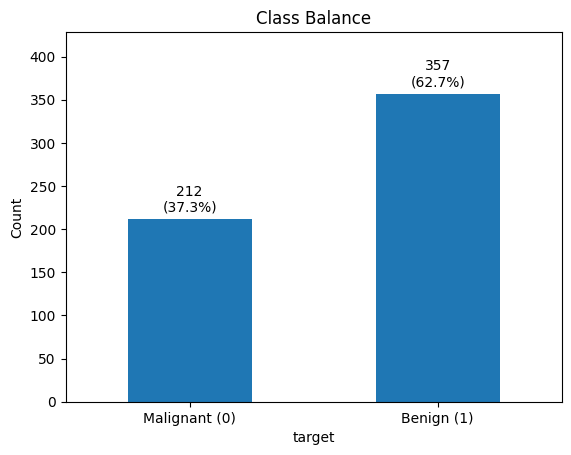

In [27]:
# Plots the class balance with counts and percentages
counts = y_data.value_counts().sort_index()
ax = counts.plot(kind='bar', title='Class Balance')
total = len(y_data)

for i, v in enumerate(counts):
    percentage = (v / total) * 100
    ax.text(i, v + 5, f'{v}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.xticks([0, 1], ['Malignant (0)', 'Benign (1)'], rotation=0)
plt.ylabel('Count')
plt.ylim(0, max(counts) * 1.2)

# Save the plot
save_plot(plt.gcf(), config['plots']['eda']['class_balance'])

plt.show()

**Feature Means/SD**

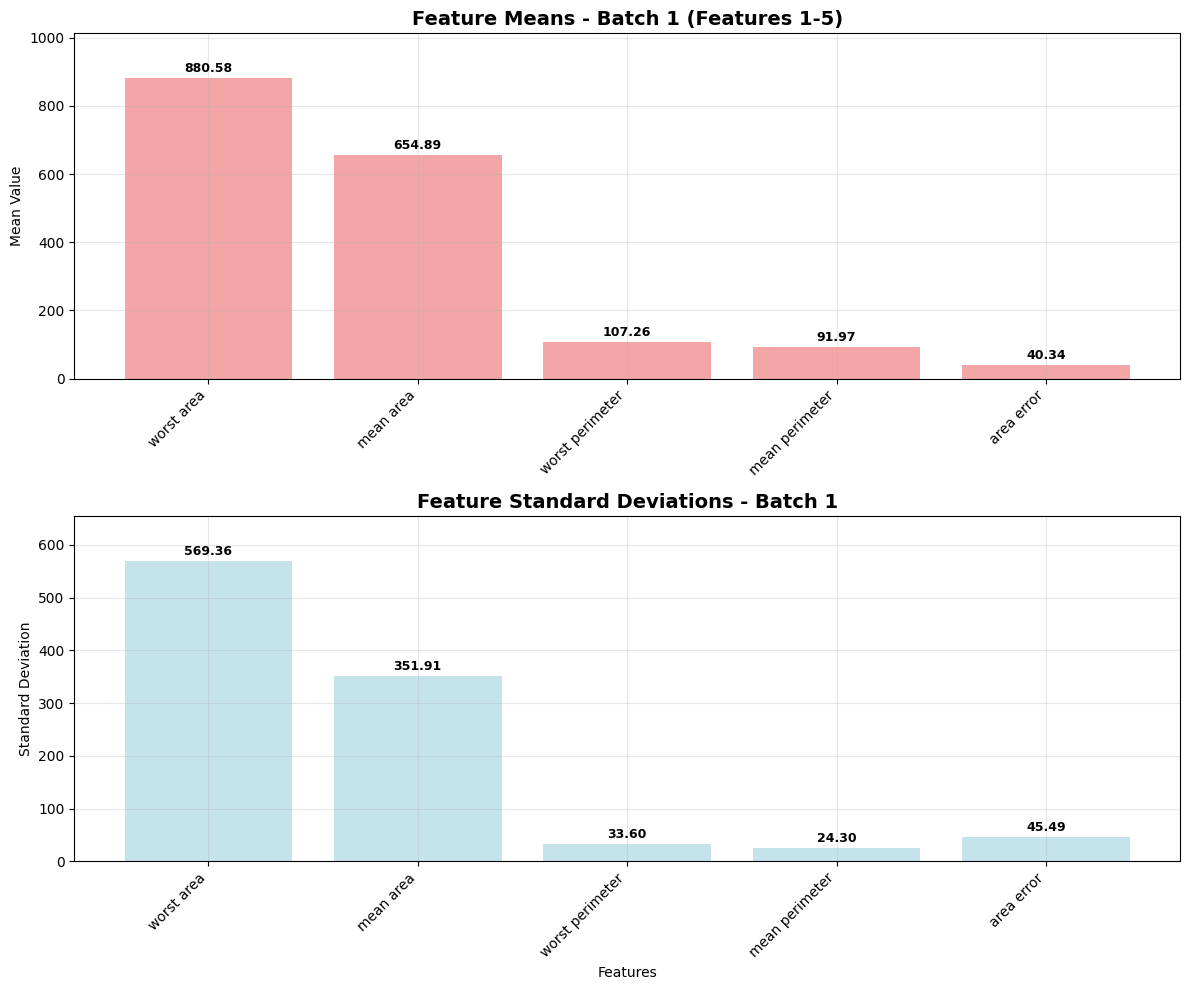

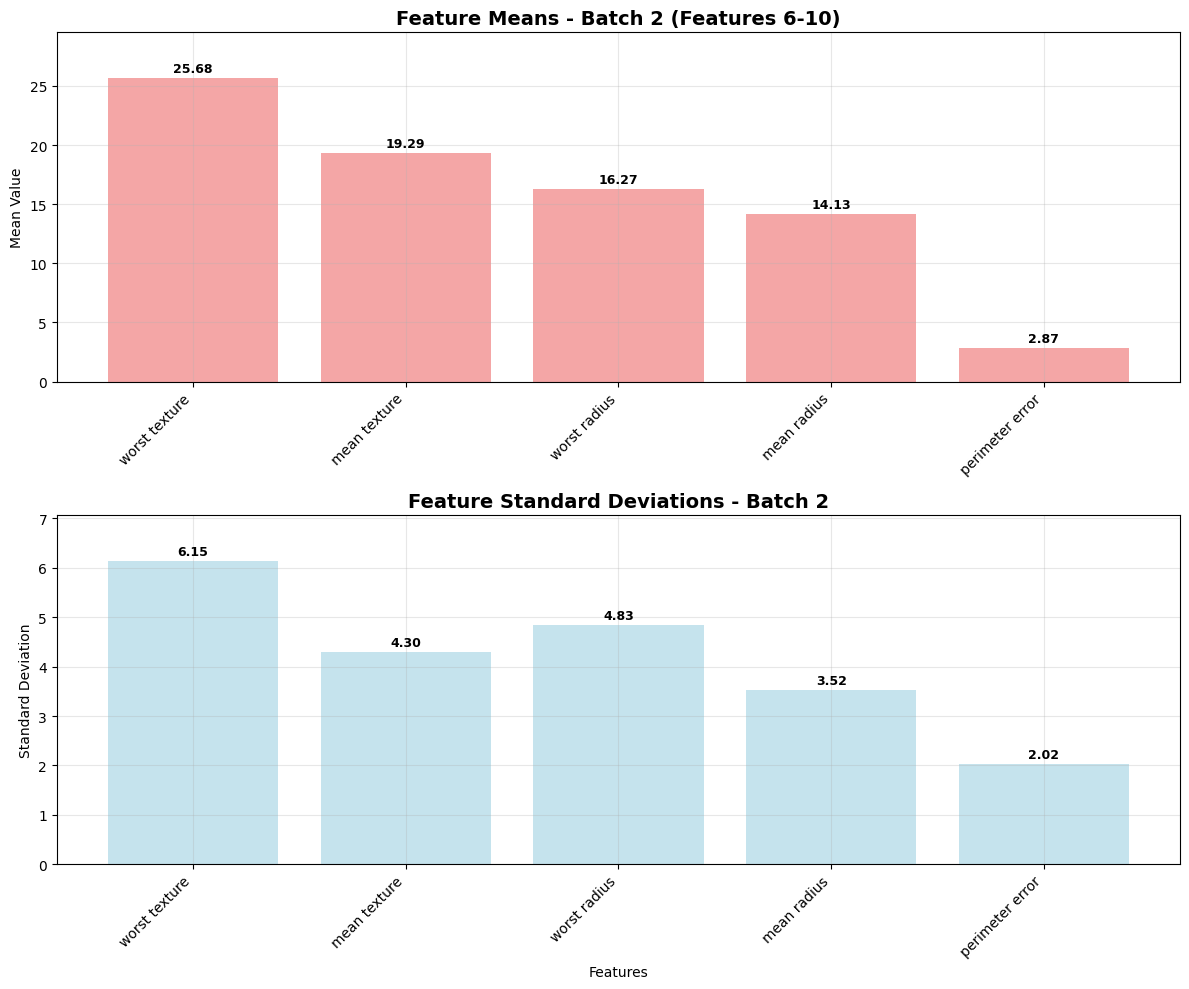

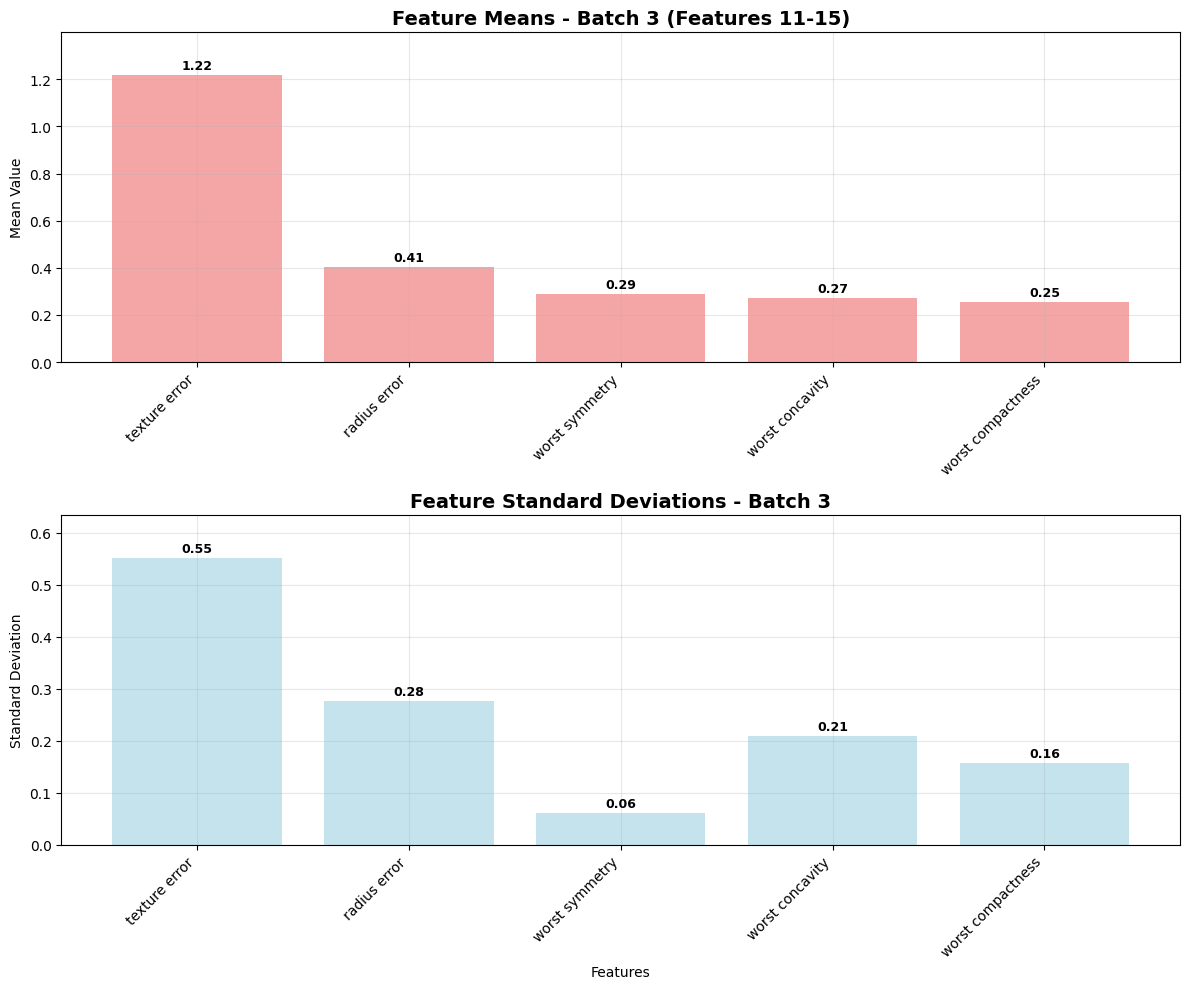

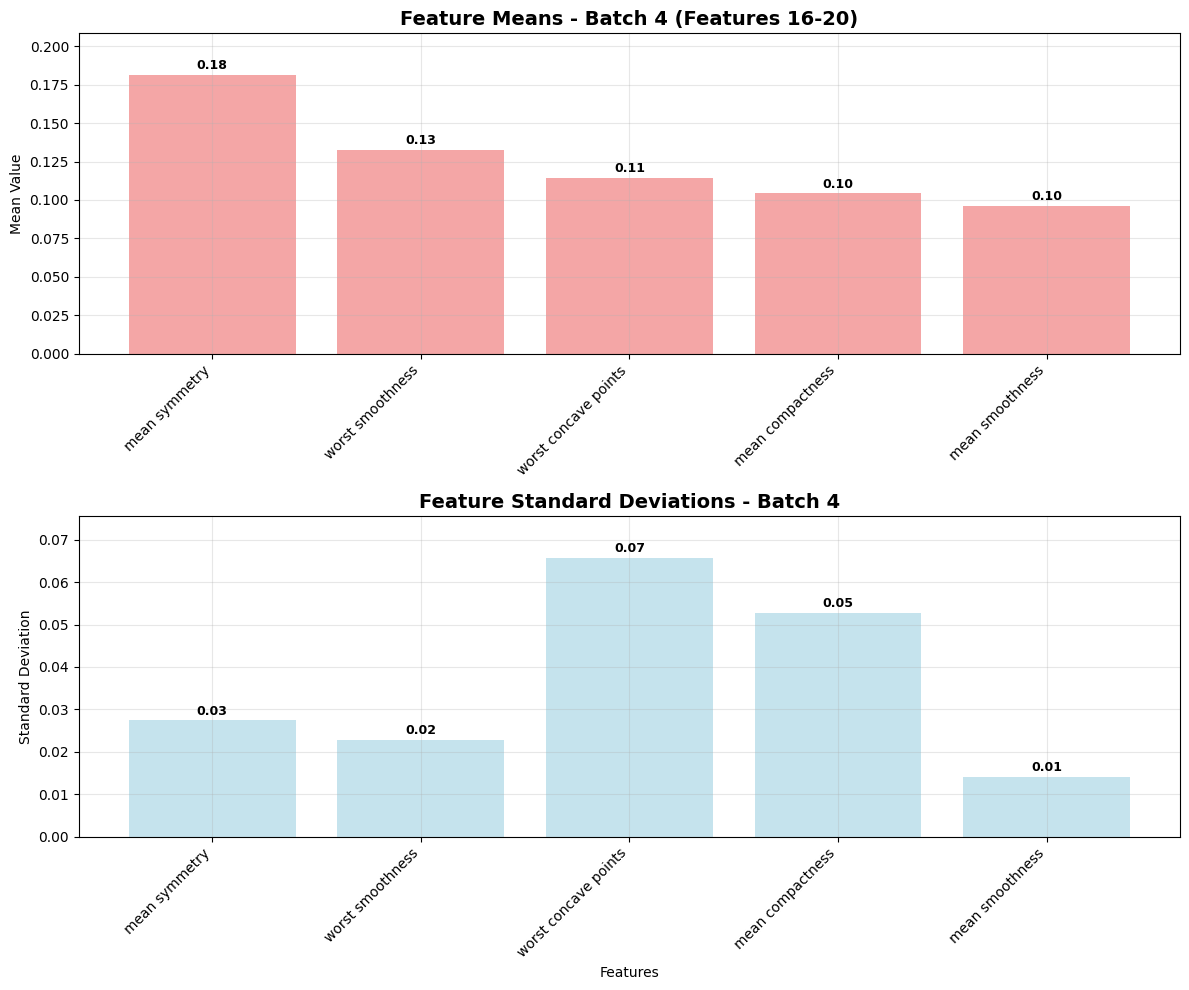

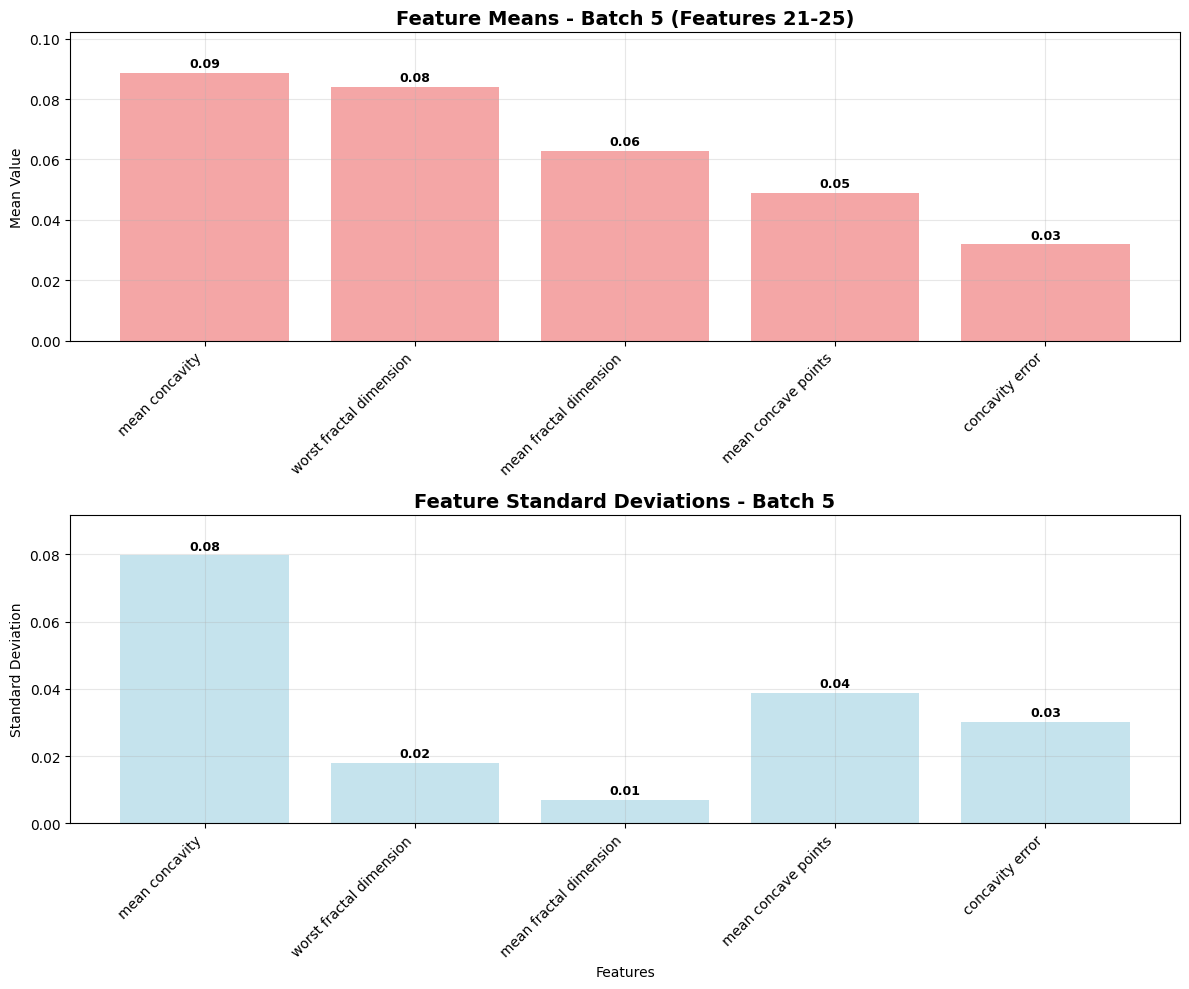

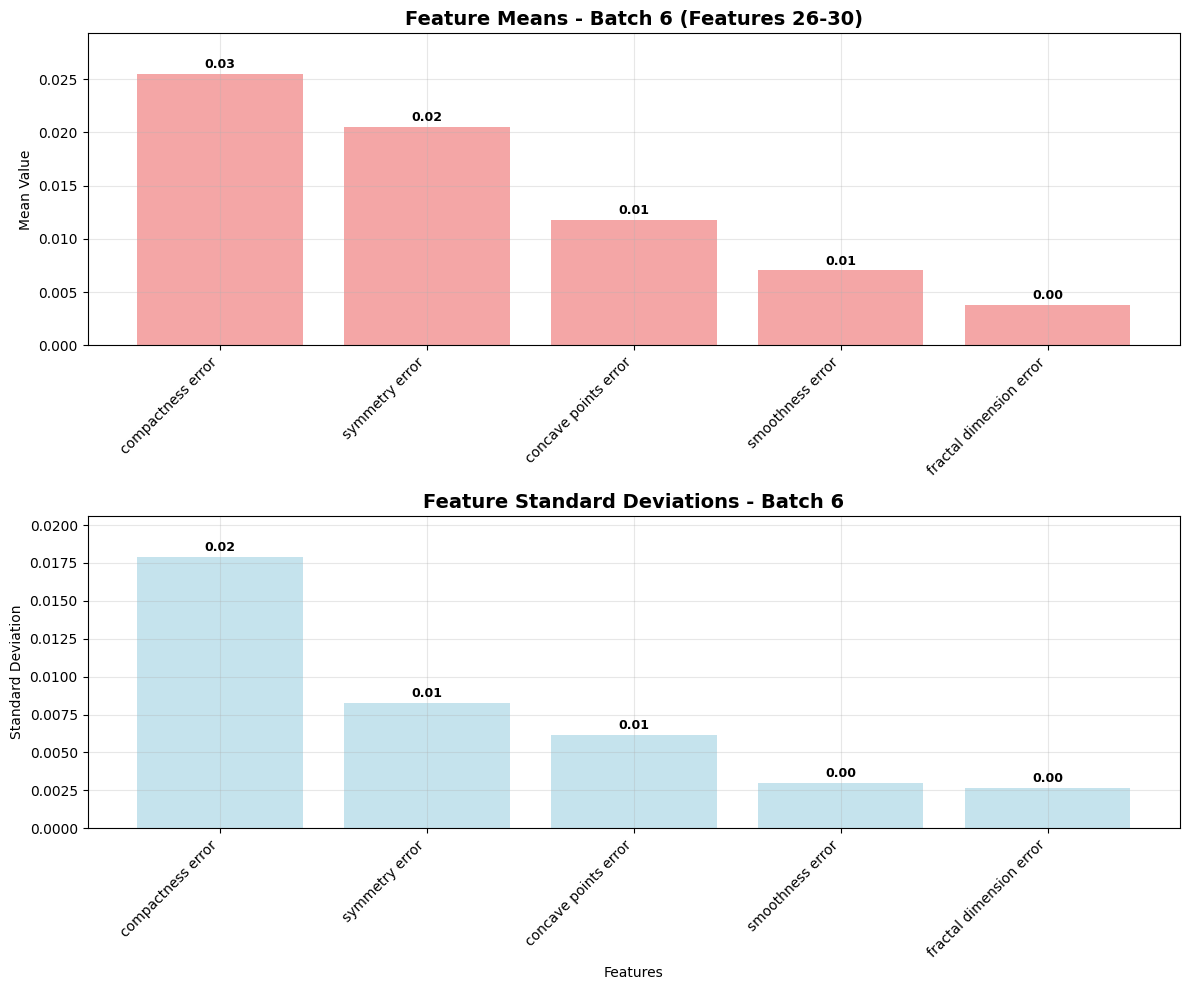

Feature Statistics Summary:
Number of features: 30
Number of batches created: 6

Means:
  Mean of means: 61.8907
  Std of means: 195.8614
  Min mean: 0.0038 (fractal dimension error)
  Max mean: 880.5831 (worst area)

Standard Deviations:
  Mean of SDs: 34.9047
  Std of SDs: 119.6758
  Min SD: 0.0026 (fractal dimension error)
  Max SD: 569.3570 (worst area)


In [28]:
# Feature means and standard deviations
feature_means = X_data.mean().sort_values(ascending=False)
feature_stds = X_data.std()

# Plot all features in batches of 5
batch_size = 5
num_features = len(feature_means)
num_batches = (num_features + batch_size - 1) // batch_size

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, num_features)
    
    # Features for this batch (maintain sorting order)
    batch_feature_names = feature_means.iloc[start_idx:end_idx].index
    batch_means = feature_means.iloc[start_idx:end_idx]
    batch_stds = feature_stds[batch_feature_names]  # SDs for same features
    
    # Figure with subplots for this batch
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # -------------------------------- MEANS PLOT -------------------------------- #
    bars1 = ax1.bar(range(len(batch_means)), batch_means.values, color='lightcoral', alpha=0.7)
    ax1.set_title(f'Feature Means - Batch {batch_idx + 1} (Features {start_idx + 1}-{end_idx})', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Mean Value')
    ax1.set_xticks(range(len(batch_means)))
    ax1.set_xticklabels(batch_means.index, rotation=45, ha='right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Automatic padding for means plot
    max_mean = max(batch_means.values)
    padding_mean = max_mean * 0.15  # 15% padding
    ax1.set_ylim(0, max_mean + padding_mean)
    
    # Value labels on mean bars
    for i, v in enumerate(batch_means.values):
        ax1.text(i, v + max_mean * 0.01, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    # ---------------------------------------------------------------------------- #

    # ------------------------- STANDARD DEVIATIONS PLOT ------------------------- #
    bars2 = ax2.bar(range(len(batch_stds)), batch_stds.values, color='lightblue', alpha=0.7)
    ax2.set_title(f'Feature Standard Deviations - Batch {batch_idx + 1}', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Standard Deviation')
    ax2.set_xticks(range(len(batch_stds)))
    ax2.set_xticklabels(batch_stds.index, rotation=45, ha='right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Automatic padding for standard deviations plot
    max_std = max(batch_stds.values)
    padding_std = max_std * 0.15  # 15% padding
    ax2.set_ylim(0, max_std + padding_std)
    
    # Value labels on SD bars
    for i, v in enumerate(batch_stds.values):
        ax2.text(i, v + max_std * 0.01, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    # ---------------------------------------------------------------------------- #

    plt.tight_layout()

    # Save every plot
    save_plot(fig, f"{config['plots']['eda']['feature_means_std']}_batch_{batch_idx + 1}")
    
    plt.show()
    
# Means and SDs summary
print("Feature Statistics Summary:")
print(f"Number of features: {len(feature_means)}")
print(f"Number of batches created: {num_batches}")
print("\nMeans:")
print(f"  Mean of means: {feature_means.mean():.4f}")
print(f"  Std of means: {feature_means.std():.4f}")
print(f"  Min mean: {feature_means.min():.4f} ({feature_means.idxmin()})")
print(f"  Max mean: {feature_means.max():.4f} ({feature_means.idxmax()})")
print("\nStandard Deviations:")
print(f"  Mean of SDs: {feature_stds.mean():.4f}")
print(f"  Std of SDs: {feature_stds.std():.4f}")
print(f"  Min SD: {feature_stds.min():.4f} ({feature_stds.idxmin()})")
print(f"  Max SD: {feature_stds.max():.4f} ({feature_stds.idxmax()})")

**Correlation Heatmap**

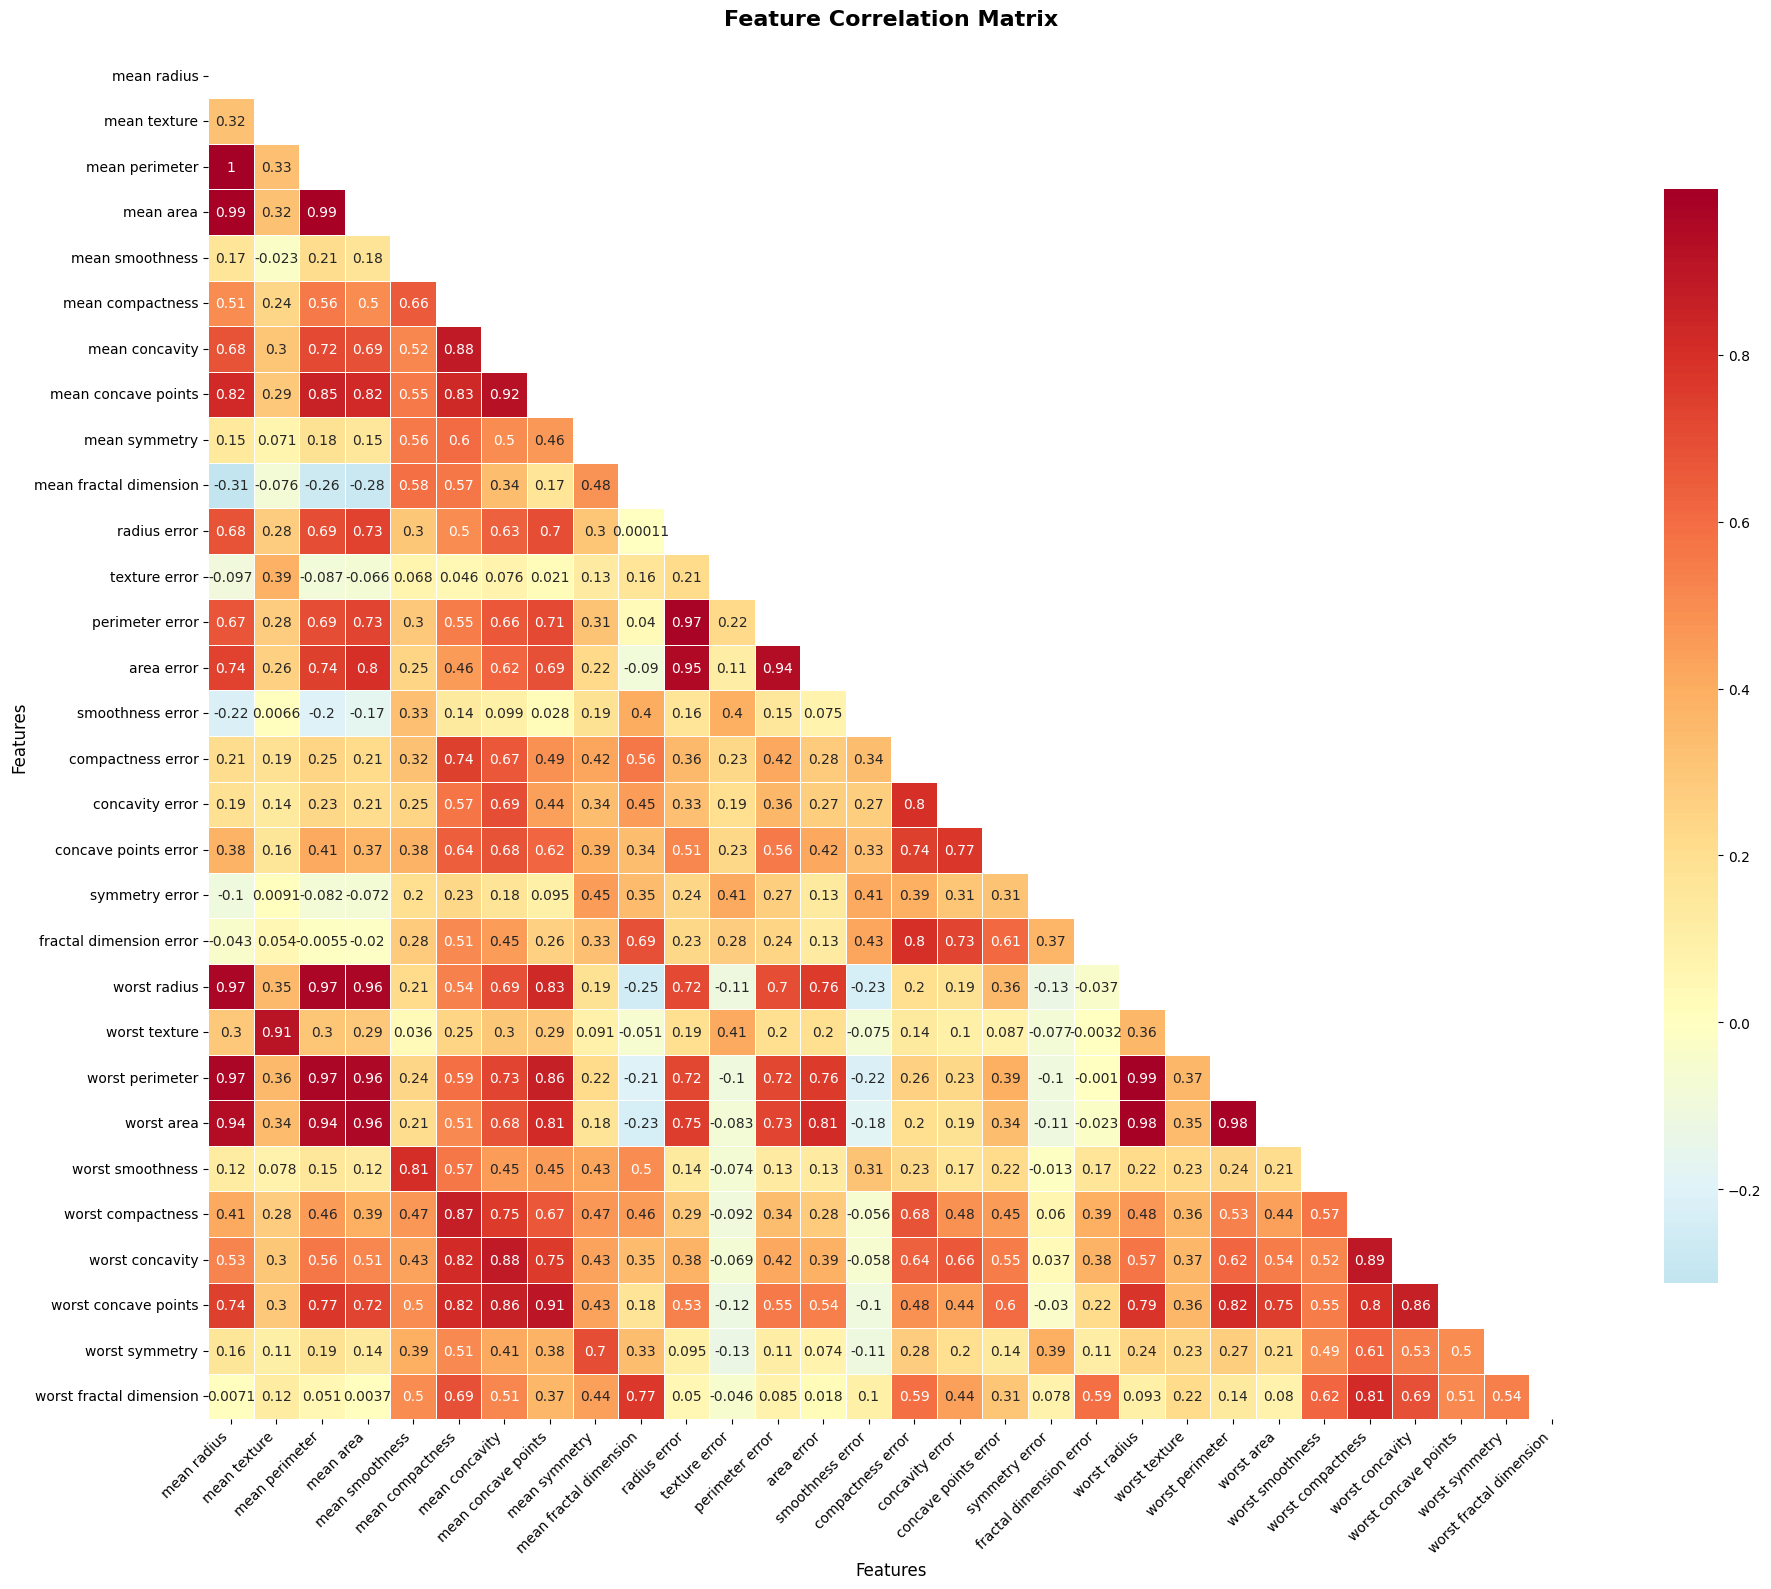

Correlation Analysis:
Highest positive correlation: 1.0000
Highest negative correlation: -0.3116

Highly Correlated Pairs: 44
mean radius <-> mean perimeter: 0.9979
worst radius <-> worst perimeter: 0.9937
mean radius <-> mean area: 0.9874
mean perimeter <-> mean area: 0.9865
worst radius <-> worst area: 0.9840
worst perimeter <-> worst area: 0.9776
radius error <-> perimeter error: 0.9728
mean perimeter <-> worst perimeter: 0.9704
mean radius <-> worst radius: 0.9695
mean perimeter <-> worst radius: 0.9695


In [29]:
# Correlation matrix
corr_matrix = X_data.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Ignore upper triangle

heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                      square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
save_plot(fig, config['plots']['eda']['correlation_heatmap'])

plt.show()

# Print some correlation insights
print("Correlation Analysis:")
print(f"Highest positive correlation: {corr_matrix.max().max():.4f}")
print(f"Highest negative correlation: {corr_matrix.min().min():.4f}")

# Find high correlation pairs (exclude self-correlation)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # High correlation threshold #type: ignore
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

print(f"\nHighly Correlated Pairs: {len(high_corr_pairs)}")
for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
    print(f"{feat1} <-> {feat2}: {corr_val:.4f}")

## 2. Create Two Non-IID Hospital Splits

### 2.1 Shuffle with Fixed Seed

In [30]:
X_shuffled, y_shuffled = utils.shuffle(X_data, y_data, random_state=RANDOM_SEED)    #type: ignore

**Verify Integrity of Feature-Target Pairs**

In [31]:
X_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [32]:
y_data.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [33]:
X_shuffled.head()   #type: ignore

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


In [34]:
y_shuffled.head()   #type: ignore

204    1
70     0
131    0
431    1
540    1
Name: target, dtype: int64

### 2.2 External Test Split

In [35]:
# Split shuffled data into train (80%) and external test (20%)
X_train_full, X_test, y_train_full, y_test = model_selection.train_test_split(
    X_shuffled, y_shuffled, 
    test_size=0.2, 
    random_state=RANDOM_SEED, 
    stratify=y_shuffled #type: ignore
)

print(f"Full dataset size: {len(X_shuffled)}")                                                  #type: ignore
print(f"Training set size: {len(X_train_full)} ({len(X_train_full)/len(X_shuffled)*100:.1f}%)") #type: ignore
print(f"External test set size: {len(X_test)} ({len(X_test)/len(X_shuffled)*100:.1f}%)")        #type: ignore

# Class distribution in test set
print(f"\nClass distribution in test set:")
test_counts = y_test.value_counts().sort_index()
print(f"Malignant (0): {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"Benign (1): {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")

Full dataset size: 569
Training set size: 455 (80.0%)
External test set size: 114 (20.0%)

Class distribution in test set:
Malignant (0): 42 (36.8%)
Benign (1): 72 (63.2%)


### 2.3 Creating Data Shards Using Feature Shift (Option B)

According to the correlation matrix, ```mean radius``` feature has the highest correlation. Therefore, feature shift will be done based on ```mean radius```.

Threshold strategy is mean + (std / 2) of ```mean radius```.

In [36]:
# Data shards from the training data
feature_for_feature_shift = config['values']['FEATURE_SHIFT']
threshold = X_train_full[feature_for_feature_shift].mean() + X_train_full[feature_for_feature_shift].std() / 2
print(f"\nFeature for feature shift: {feature_for_feature_shift}")
print(f"Feature shift threshold: {threshold}")

# Shards based on mean radius threshold
high_radius_mask = X_train_full[feature_for_feature_shift] > threshold

# High shard: mean radius > threshold
high_shard_X = X_train_full[high_radius_mask]
high_shard_y = y_train_full[high_radius_mask]

# Low shard: mean radius <= threshold
low_radius_mask = X_train_full[feature_for_feature_shift] <= threshold
low_shard_X = X_train_full[low_radius_mask]
low_shard_y = y_train_full[low_radius_mask]

# Print shard sizes
print(f"\nHigh Shard Size: {len(high_shard_X)} ({len(high_shard_X)/len(X_train_full)*100:.1f}%)")
print(f"Low Shard Size: {len(low_shard_X)} ({len(low_shard_X)/len(X_train_full)*100:.1f}%)")

# Class distribution for each hospital
print(f"\nClass distribution in hospital shards:")
print(f"High Shard - Malignant: {(high_shard_y == 0).sum()}, Benign: {(high_shard_y == 1).sum()}")
print(f"Low Shard - Malignant: {(low_shard_y == 0).sum()}, Benign: {(low_shard_y == 1).sum()}")


Feature for feature shift: mean radius
Feature shift threshold: 16.021109368709094

High Shard Size: 118 (25.9%)
Low Shard Size: 337 (74.1%)

Class distribution in hospital shards:
High Shard - Malignant: 114, Benign: 4
Low Shard - Malignant: 56, Benign: 281


### 2.4 Combine Shards with Their Targets

In [37]:
hospital_a = high_shard_X.copy()
hospital_a['target'] = high_shard_y

hospital_b = low_shard_X.copy()
hospital_b['target'] = low_shard_y

test_df = X_test.copy()
test_df['target'] = y_test

### 2.5 Check Data Leakage Among All Sets

In [38]:
# Get indices for each dataset
hospital_a_indices = set(hospital_a.index)
hospital_b_indices = set(hospital_b.index)
test_indices = set(test_df.index)

print("Dataset Sizes:")
print(f"Hospital A: {len(hospital_a_indices)} samples")
print(f"Hospital B: {len(hospital_b_indices)} samples")
print(f"Test Set: {len(test_indices)} samples")
print(f"Total: {len(hospital_a_indices) + len(hospital_b_indices) + len(test_indices)} samples")

# ----------------------- CHECK FOR OVERLAPPING INDICES ---------------------- #
print("\nOverlaps:")
# Hospital A vs Hospital B
overlap_a_b = hospital_a_indices.intersection(hospital_b_indices)
print(f"Hospital A ∩ Hospital B: {len(overlap_a_b)} samples")
if len(overlap_a_b) > 0:
    print(f"  LEAKAGE DETECTED: {list(overlap_a_b)[:10]}")

# Hospital A vs Test Set
overlap_a_test = hospital_a_indices.intersection(test_indices)
print(f"Hospital A ∩ Test Set: {len(overlap_a_test)} samples")
if len(overlap_a_test) > 0:
    print(f"  LEAKAGE DETECTED: {list(overlap_a_test)[:10]}")

# Hospital B vs Test Set
overlap_b_test = hospital_b_indices.intersection(test_indices)
print(f"Hospital B ∩ Test Set: {len(overlap_b_test)} samples")
if len(overlap_b_test) > 0:
    print(f"  LEAKAGE DETECTED: {list(overlap_b_test)[:10]}")

# Three-way overlap
overlap_all = hospital_a_indices.intersection(hospital_b_indices).intersection(test_indices)
print(f"All three datasets: {len(overlap_all)} samples")
if len(overlap_all) > 0:
    print(f"  CRITICAL LEAKAGE: {list(overlap_all)}")

# Union check - should equal original dataset size
total_unique = len(hospital_a_indices.union(hospital_b_indices).union(test_indices))
original_size = len(X_shuffled)  #type: ignore

print(f"\nTotal unique samples across all splits: {total_unique}")
print(f"Original dataset size: {original_size}")
print(f"All samples accounted for: {total_unique == original_size}")
# ---------------------------------------------------------------------------- #

# Results
total_overlaps = len(overlap_a_b) + len(overlap_a_test) + len(overlap_b_test) + len(overlap_all)
if total_overlaps == 0:
    print("NO DATA LEAKAGE DETECTED")
else:
    raise ValueError(f"DATA LEAKAGE DETECTED - {total_overlaps} total overlapping instances found")

# ----------------------------- ADDITIONAL CHECKS ---------------------------- #
print(f"\nAdditional Checks:")

# Check if splits preserve original data distribution
original_malignant = (y_shuffled == 0).sum()  #type: ignore
original_benign = (y_shuffled == 1).sum()     #type: ignore

split_malignant = (hospital_a['target'] == 0).sum() + (hospital_b['target'] == 0).sum() + (test_df['target'] == 0).sum()
split_benign = (hospital_a['target'] == 1).sum() + (hospital_b['target'] == 1).sum() + (test_df['target'] == 1).sum()

print(f"Original - Malignant: {original_malignant}, Benign: {original_benign}")
print(f"Splits - Malignant: {split_malignant}, Benign: {split_benign}")
print(f"Class counts preserved: {original_malignant == split_malignant and original_benign == split_benign}")

Dataset Sizes:
Hospital A: 118 samples
Hospital B: 337 samples
Test Set: 114 samples
Total: 569 samples

Overlaps:
Hospital A ∩ Hospital B: 0 samples
Hospital A ∩ Test Set: 0 samples
Hospital B ∩ Test Set: 0 samples
All three datasets: 0 samples

Total unique samples across all splits: 569
Original dataset size: 569
All samples accounted for: True
NO DATA LEAKAGE DETECTED

Additional Checks:
Original - Malignant: 212, Benign: 357
Splits - Malignant: 212, Benign: 357
Class counts preserved: True


### 2.6 Exporting the Data Splits

In [39]:
# Create data directory if it doesn't exist
data_dir = os.path.join('..', config['directories']['data'])
os.makedirs(data_dir, exist_ok=True)

# Corresponding paths
hospital_a_path = os.path.join(data_dir, config['values']['hospital_a_export'])
hospital_b_path = os.path.join(data_dir, config['values']['hospital_b_export'])
test_path = os.path.join(data_dir, config['values']['test_set_export'])

# Export to CSV
hospital_a.to_csv(hospital_a_path, index=False)
hospital_b.to_csv(hospital_b_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"Hospital A dataset exported: {hospital_a_path}")
print(f"Shape: {hospital_a.shape}")
print(f"Class distribution: Malignant={len(hospital_a[hospital_a['target']==0])}, Benign={len(hospital_a[hospital_a['target']==1])}")

print(f"\nHospital B dataset exported: {hospital_b_path}")
print(f"Shape: {hospital_b.shape}")
print(f"Class distribution: Malignant={len(hospital_b[hospital_b['target']==0])}, Benign={len(hospital_b[hospital_b['target']==1])}")

print(f"\nTest dataset exported: {test_path}")
print(f"Shape: {test_df.shape}")
print(f"Class distribution: Malignant={len(test_df[test_df['target']==0])}, Benign={len(test_df[test_df['target']==1])}")

# Verify data integrity
print(f"\nData integrity check:")
print(f"Original training size: {len(X_train_full)}")
print(f"Combined hospital sizes: {len(hospital_a) + len(hospital_b)}")
print(f"Match: {len(X_train_full) == len(hospital_a) + len(hospital_b)}")

Hospital A dataset exported: ../data/hospital_a.csv
Shape: (118, 31)
Class distribution: Malignant=114, Benign=4

Hospital B dataset exported: ../data/hospital_b.csv
Shape: (337, 31)
Class distribution: Malignant=56, Benign=281

Test dataset exported: ../data/test_set.csv
Shape: (114, 31)
Class distribution: Malignant=42, Benign=72

Data integrity check:
Original training size: 455
Combined hospital sizes: 455
Match: True
